# Support Vector Machines

## Introduction

Support Vector Machines (SVMs) are powerful supervised learning algorithms used for classification, regression, and outlier detection. SVMs are particularly effective in high-dimensional spaces and are widely used due to their strong theoretical guarantees and practical effectiveness.

### Mathematical Principles

SVM works by finding the optimal hyperplane that maximizes the margin between different classes in the feature space. For linearly separable data, the decision boundary is defined as:

$$w \cdot x + b = 0$$

Where:
- $w$ is the normal vector to the hyperplane
- $b$ is the bias term
- $x$ represents the feature vectors

The optimization problem aims to maximize the margin ($\frac{2}{||w||}$) while ensuring correct classification:

$$\min_{w,b} \frac{1}{2}||w||^2$$
$$\text{subject to } y_i(w \cdot x_i + b) \geq 1 \text{ for all } i$$

For non-linearly separable data, SVMs use the kernel trick to map the input space to a higher-dimensional feature space where a linear separator might exist. Common kernels include:

- **Linear**: $K(x_i, x_j) = x_i \cdot x_j$
- **Polynomial**: $K(x_i, x_j) = (\gamma x_i \cdot x_j + r)^d$
- **Radial Basis Function (RBF)**: $K(x_i, x_j) = \exp(-\gamma ||x_i - x_j||^2)$
- **Sigmoid**: $K(x_i, x_j) = \tanh(\gamma x_i \cdot x_j + r)$

SVMs also introduce a regularization parameter $C$ that controls the trade-off between maximizing the margin and minimizing the classification error.

## 1. Setup and Data Loading

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.decomposition import PCA
import joblib
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Load the Breast Cancer Wisconsin dataset
from sklearn.datasets import load_breast_cancer

# Load dataset
cancer = load_breast_cancer()

# Create a pandas DataFrame for easier manipulation
data = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data['target'] = cancer.target

# Display basic dataset information
print(f"Dataset shape: {data.shape}")
print("\nFeature names:")
for i, feature in enumerate(cancer.feature_names[:5]):
    print(f"  {i+1}. {feature}")
print("...and more features")
    
print("\nTarget classes:")
for i, target in enumerate(cancer.target_names):
    print(f"  {i}. {target}")

# Display the first few rows of the dataset
data.head()

Dataset shape: (569, 31)

Feature names:
  1. mean radius
  2. mean texture
  3. mean perimeter
  4. mean area
  5. mean smoothness
...and more features

Target classes:
  0. malignant
  1. benign


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## 2. Exploratory Data Analysis (EDA)

In [3]:
# Basic statistical summary
data.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [4]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64


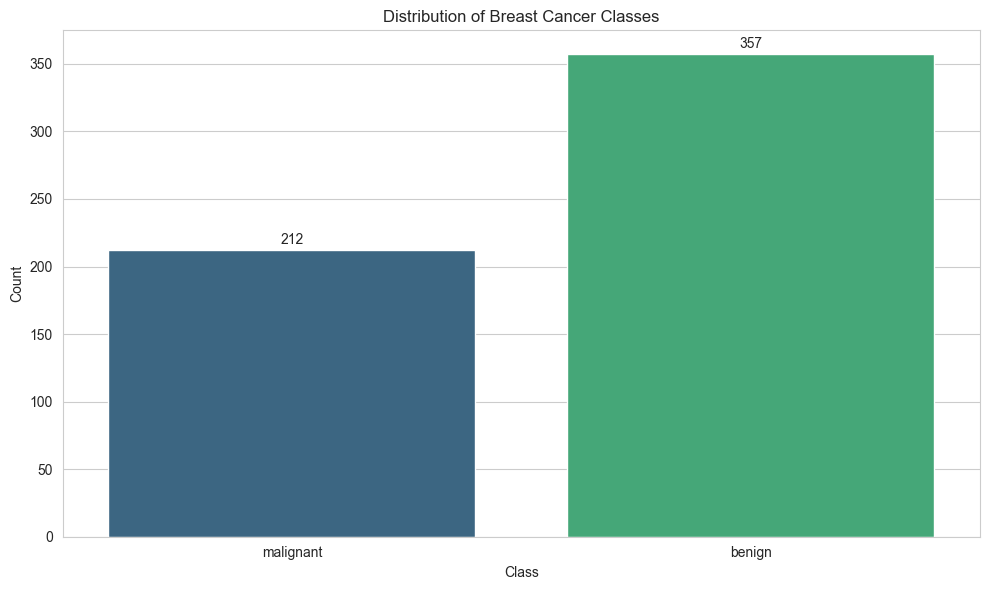

In [5]:
# Distribution of target classes
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=data, palette='viridis')
plt.title('Distribution of Breast Cancer Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], cancer.target_names)
for i, count in enumerate(data['target'].value_counts().sort_index()):
    plt.text(i, count + 5, str(count), ha='center')
plt.tight_layout()
plt.show()

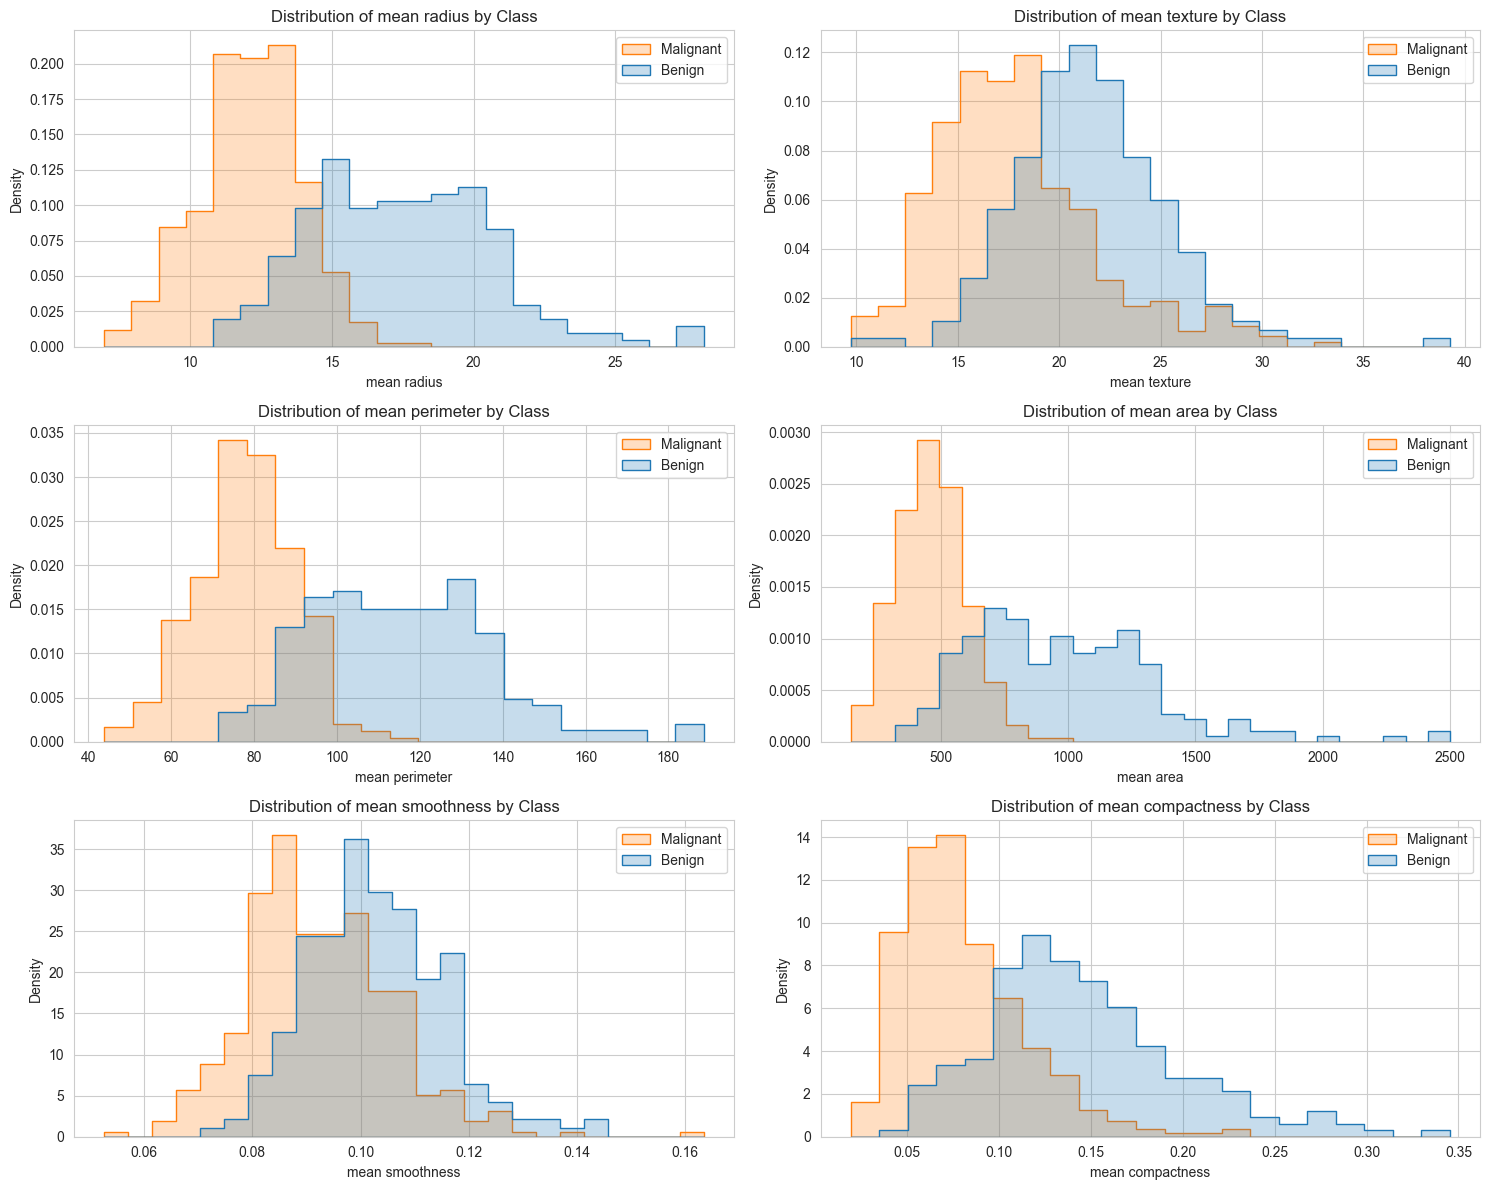

In [6]:
# Feature distributions by class for selected features
selected_features = [
    'mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness',
    'mean compactness'
]

plt.figure(figsize=(15, 12))
for i, feature in enumerate(selected_features):
    plt.subplot(3, 2, i+1)
    sns.histplot(data=data, x=feature, hue='target', element='step', stat='density', common_norm=False)
    plt.title(f'Distribution of {feature} by Class')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend(['Malignant', 'Benign'])
    
plt.tight_layout()
plt.show()

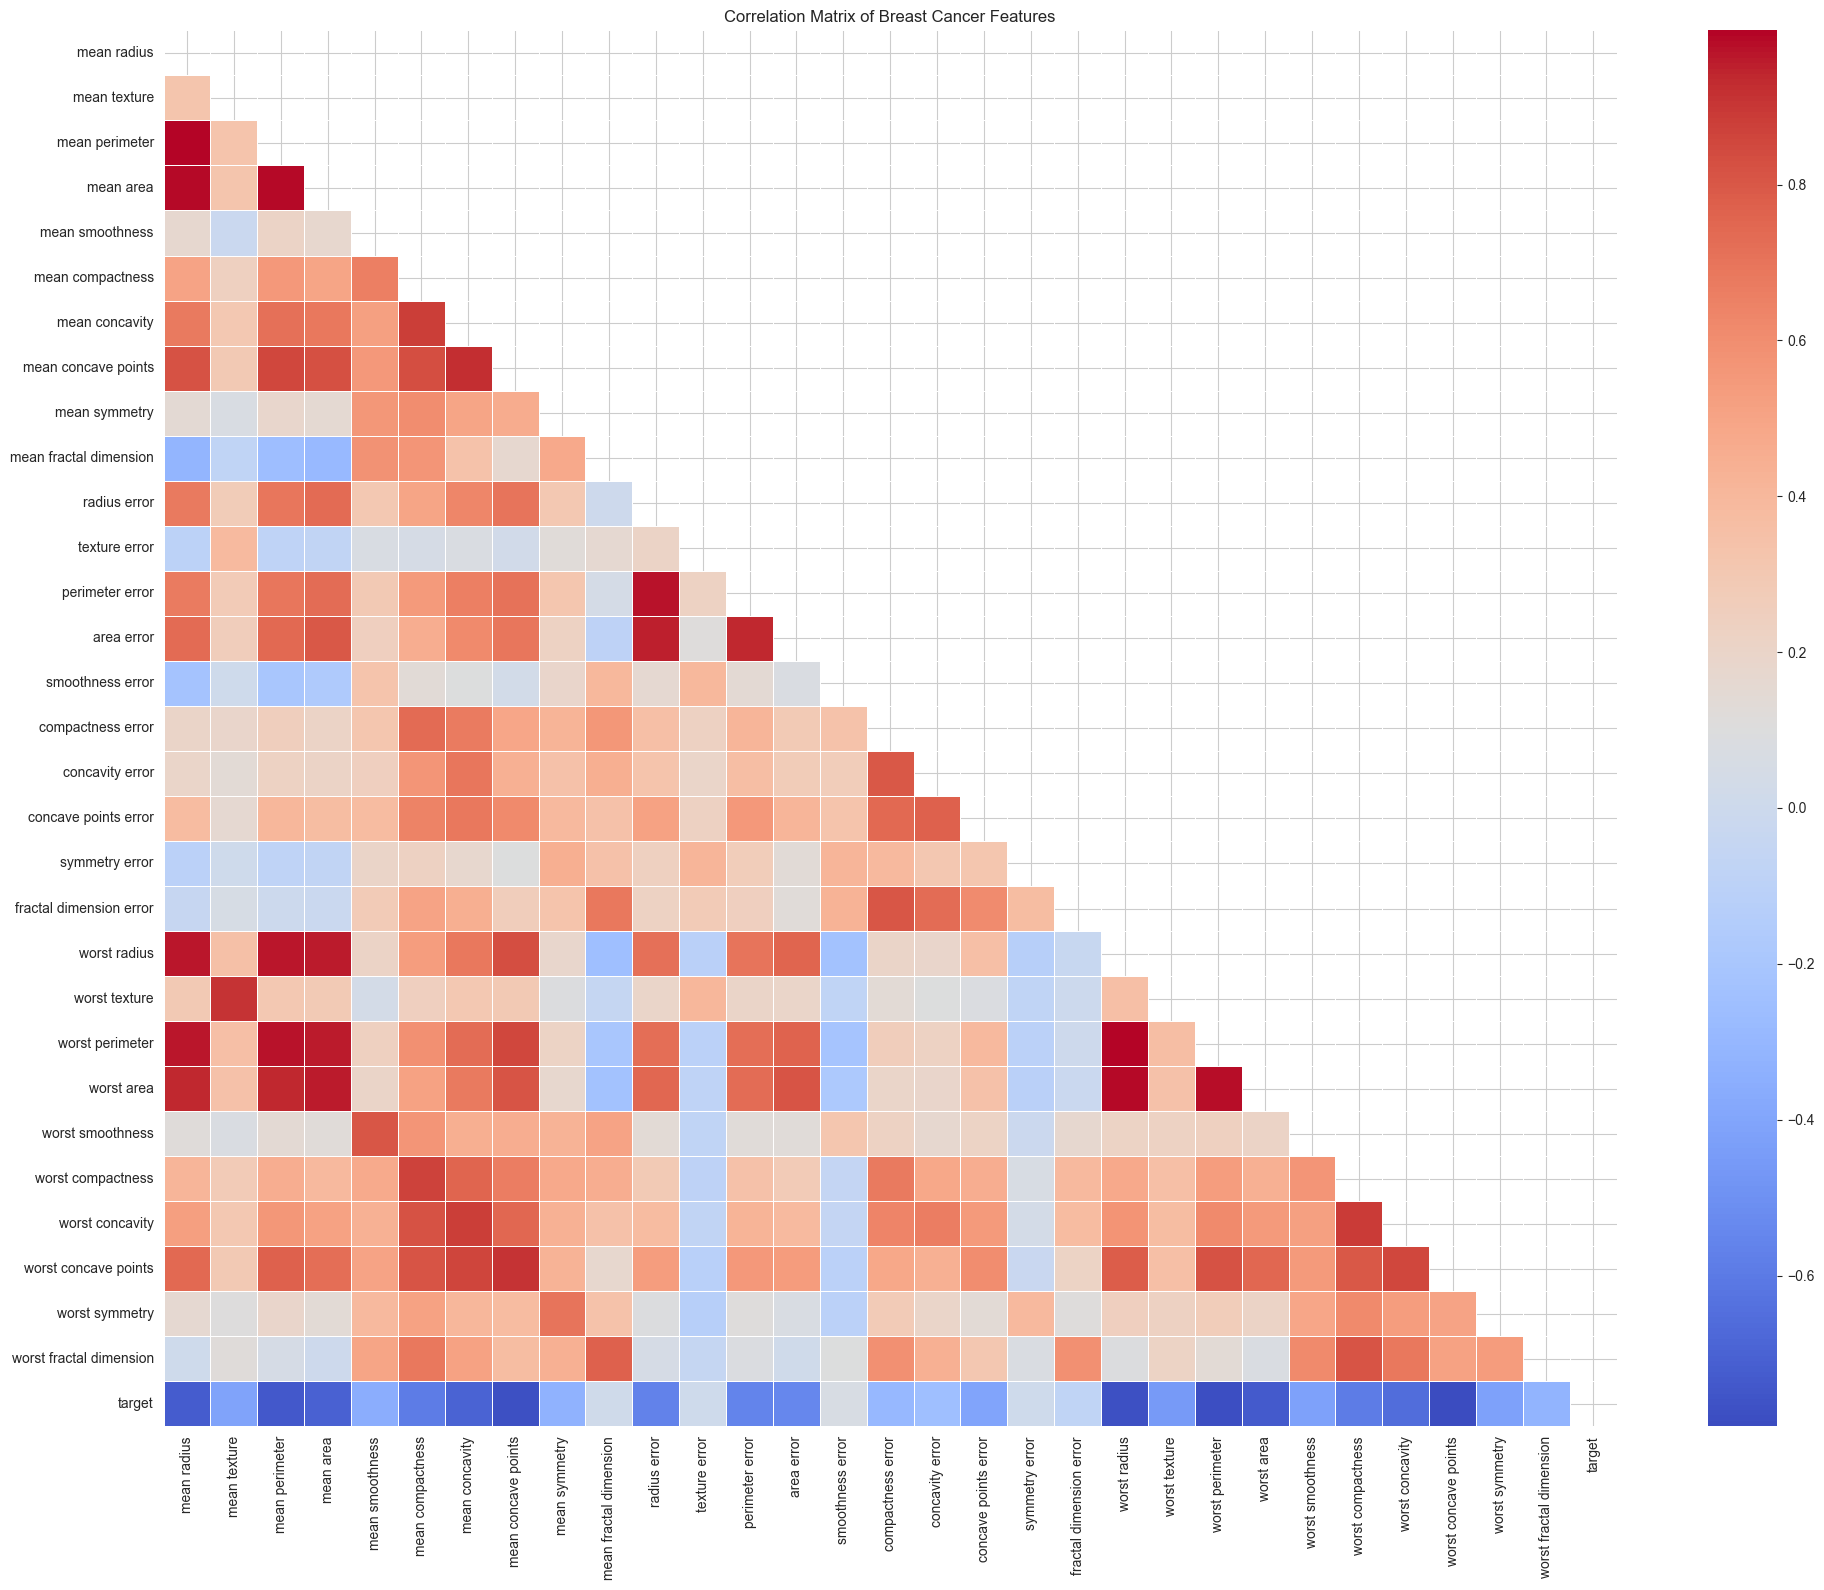

In [7]:
# Correlation matrix
plt.figure(figsize=(20, 16))
correlation_matrix = data.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Breast Cancer Features')
plt.tight_layout()
plt.show()

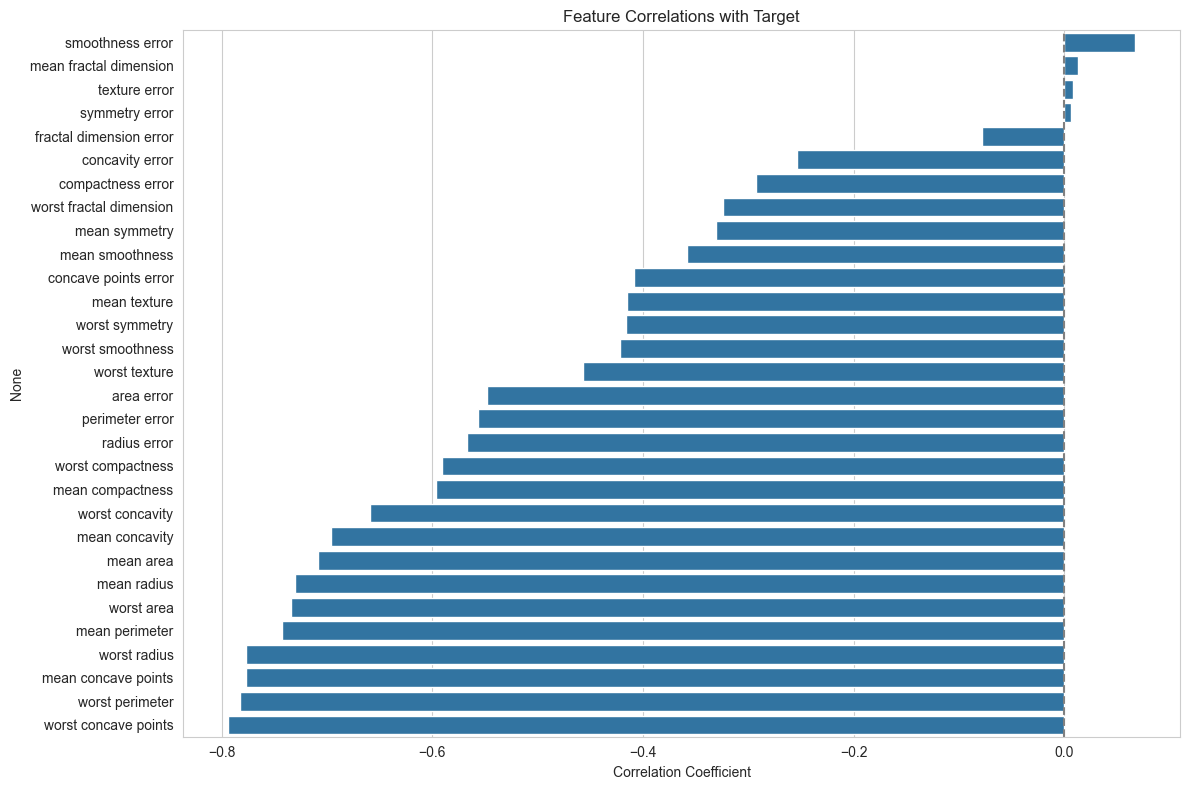

In [8]:
# Feature correlations with target
target_correlations = correlation_matrix['target'].drop('target').sort_values(ascending=False)

# Visualize top correlations
plt.figure(figsize=(12, 8))
sns.barplot(x=target_correlations.values, y=target_correlations.index)
plt.title('Feature Correlations with Target')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

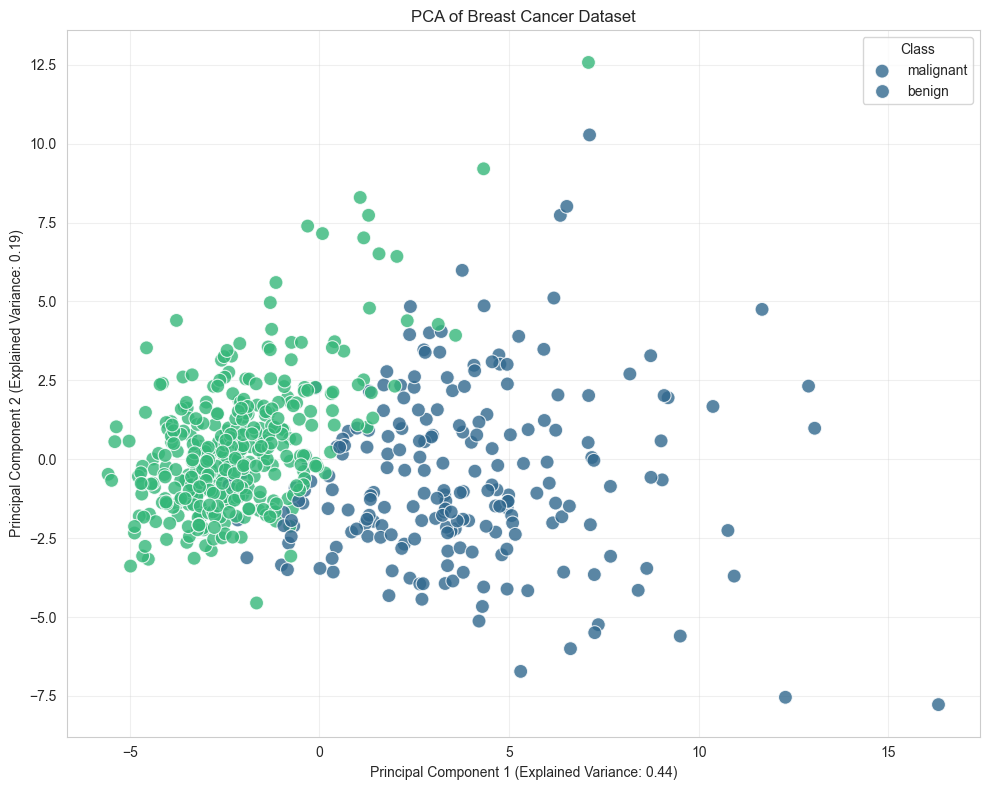

In [9]:
# Apply PCA for visualizing the data in 2D
X = data.drop('target', axis=1)
y = data['target']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['target'] = y

# Plot the data in the PCA space
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='target', data=pca_df, palette='viridis', s=100, alpha=0.8)
plt.title('PCA of Breast Cancer Dataset')
plt.xlabel(f'Principal Component 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2f})')
plt.ylabel(f'Principal Component 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2f})')
plt.legend(title='Class', labels=cancer.target_names)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [10]:
# Extract features and target variable
X = data.drop('target', axis=1)
y = data['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Testing set class distribution: {np.bincount(y_test)}")

Training set shape: (426, 30)
Testing set shape: (143, 30)
Training set class distribution: [159 267]
Testing set class distribution: [53 90]


In [11]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for better visualization
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Display scaled data statistics
X_train_scaled_df.describe().round(2)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,426.00,426.00,426.00,426.00,426.00,426.00,426.00,426.00,426.00,426.00,...,426.00,426.00,426.00,426.00,426.00,426.00,426.00,426.00,426.00,426.00
mean,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,...,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.02,-2.16,-1.98,-1.46,-2.51,-1.60,-1.10,-1.25,-2.69,-1.77,...,-1.72,-2.17,-1.69,-1.23,-2.71,-1.41,-1.27,-1.70,-2.06,-1.55
25%,-0.70,-0.74,-0.70,-0.68,-0.74,-0.75,-0.75,-0.73,-0.67,-0.71,...,-0.66,-0.74,-0.69,-0.64,-0.73,-0.69,-0.78,-0.75,-0.65,-0.67
50%,-0.23,-0.11,-0.23,-0.31,-0.04,-0.25,-0.36,-0.41,-0.08,-0.20,...,-0.27,-0.04,-0.27,-0.34,-0.03,-0.25,-0.22,-0.25,-0.14,-0.22
75%,0.48,0.56,0.50,0.33,0.66,0.51,0.54,0.67,0.54,0.47,...,0.49,0.59,0.54,0.29,0.62,0.53,0.49,0.72,0.44,0.43
max,4.00,4.50,4.01,5.35,3.49,4.60,4.17,3.72,4.48,4.80,...,3.52,3.78,3.67,4.58,3.80,4.95,4.45,2.63,5.71,6.59


## 4. Building Basic SVM Models

In [12]:
# Create an SVM model with a linear kernel
svm_linear = SVC(kernel='linear', random_state=42)

# Fit the model on the training data
svm_linear.fit(X_train_scaled, y_train)

# Make predictions
y_pred_linear = svm_linear.predict(X_test_scaled)

In [13]:
# Create an SVM model with an RBF kernel
svm_rbf = SVC(kernel='rbf', random_state=42)

# Fit the model on the training data
svm_rbf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rbf = svm_rbf.predict(X_test_scaled)

In [14]:
# Create an SVM model with a polynomial kernel
svm_poly = SVC(kernel='poly', degree=3, random_state=42)

# Fit the model on the training data
svm_poly.fit(X_train_scaled, y_train)

# Make predictions
y_pred_poly = svm_poly.predict(X_test_scaled)

In [15]:
# Evaluate the models
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"{model_name} Model Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=cancer.target_names))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cancer.target_names, yticklabels=cancer.target_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return accuracy, precision, recall, f1

Linear Kernel SVM Model Evaluation:
Accuracy: 0.9860
Precision: 0.9889
Recall: 0.9889
F1 Score: 0.9889

Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        53
      benign       0.99      0.99      0.99        90

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143



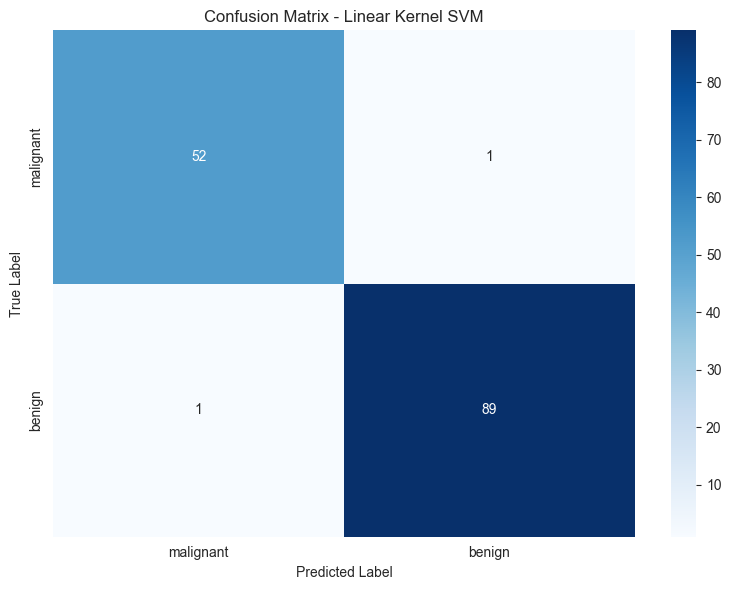

In [16]:
# Evaluate the linear kernel model
linear_scores = evaluate_model(y_test, y_pred_linear, "Linear Kernel SVM")

RBF Kernel SVM Model Evaluation:
Accuracy: 0.9790
Precision: 0.9888
Recall: 0.9778
F1 Score: 0.9832

Classification Report:
              precision    recall  f1-score   support

   malignant       0.96      0.98      0.97        53
      benign       0.99      0.98      0.98        90

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



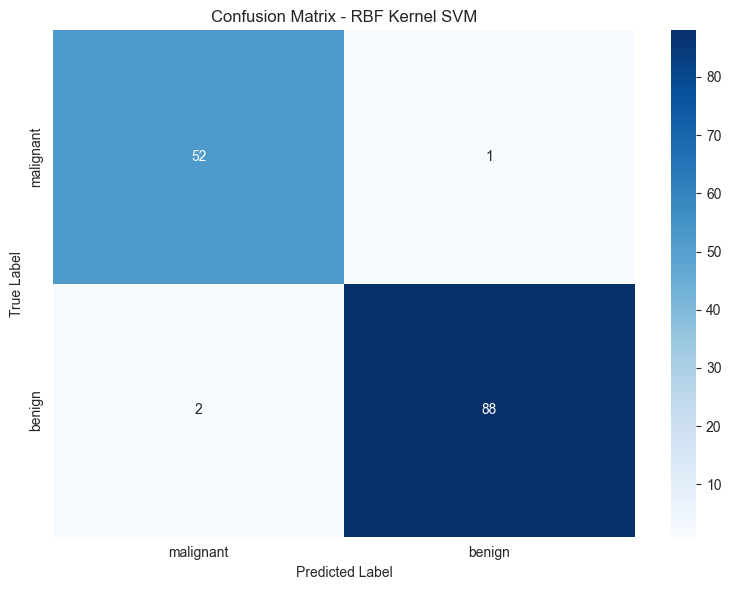

In [17]:
# Evaluate the RBF kernel model
rbf_scores = evaluate_model(y_test, y_pred_rbf, "RBF Kernel SVM")

Polynomial Kernel SVM Model Evaluation:
Accuracy: 0.9021
Precision: 0.8654
Recall: 1.0000
F1 Score: 0.9278

Classification Report:
              precision    recall  f1-score   support

   malignant       1.00      0.74      0.85        53
      benign       0.87      1.00      0.93        90

    accuracy                           0.90       143
   macro avg       0.93      0.87      0.89       143
weighted avg       0.92      0.90      0.90       143



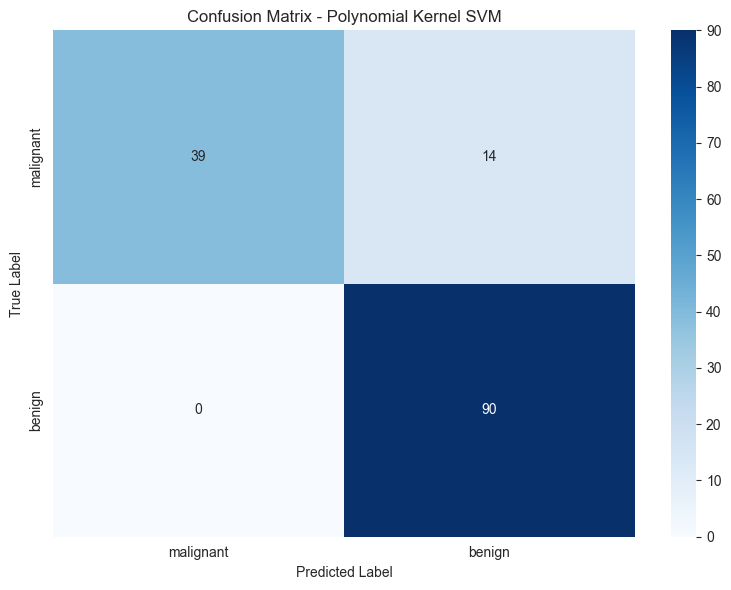

In [18]:
# Evaluate the polynomial kernel model
poly_scores = evaluate_model(y_test, y_pred_poly, "Polynomial Kernel SVM")

Model Comparison:
        Model  Accuracy  Precision  Recall  F1 Score
0  Linear SVM    0.9860     0.9889  0.9889    0.9889
1     RBF SVM    0.9790     0.9888  0.9778    0.9832
2    Poly SVM    0.9021     0.8654  1.0000    0.9278


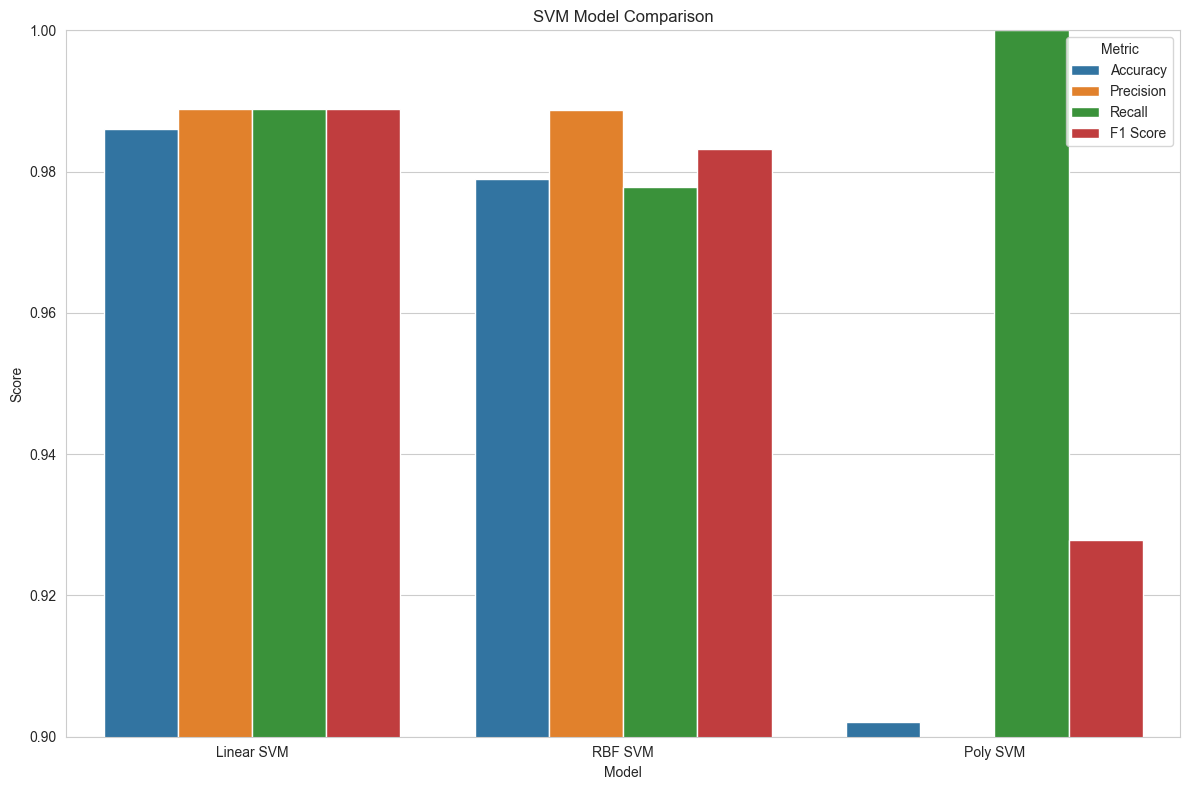

In [19]:
# Compare models
models = ['Linear SVM', 'RBF SVM', 'Poly SVM']
accuracies = [linear_scores[0], rbf_scores[0], poly_scores[0]]
precisions = [linear_scores[1], rbf_scores[1], poly_scores[1]]
recalls = [linear_scores[2], rbf_scores[2], poly_scores[2]]
f1_scores = [linear_scores[3], rbf_scores[3], poly_scores[3]]

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})

print("Model Comparison:")
print(comparison_df.round(4))

# Visualize comparison
plt.figure(figsize=(12, 8))
comparison_df_melted = pd.melt(comparison_df, id_vars=['Model'], var_name='Metric', value_name='Score')
sns.barplot(x='Model', y='Score', hue='Metric', data=comparison_df_melted)
plt.title('SVM Model Comparison')
plt.ylim(0.9, 1.0)  # Adjust as needed for better visualization
plt.tight_layout()
plt.show()

## 5. Cross-Validation

In [20]:
# Perform 5-fold stratified cross-validation for each kernel
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models
models = {
    'Linear SVM': SVC(kernel='linear', random_state=42),
    'RBF SVM': SVC(kernel='rbf', random_state=42),
    'Polynomial SVM': SVC(kernel='poly', degree=3, random_state=42)
}

# Perform cross-validation
cv_results = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    cv_results[name] = cv_scores
    
    print(f"Cross-Validation Results for {name}:")
    for i, score in enumerate(cv_scores):
        print(f"Fold {i+1}: {score:.4f}")
    print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
    print(f"Standard Deviation: {cv_scores.std():.4f}")
    print()

Cross-Validation Results for Linear SVM:
Fold 1: 0.9535
Fold 2: 0.9647
Fold 3: 0.9882
Fold 4: 0.9765
Fold 5: 0.9765
Mean CV Accuracy: 0.9719
Standard Deviation: 0.0118

Cross-Validation Results for RBF SVM:
Fold 1: 0.9651
Fold 2: 0.9647
Fold 3: 0.9647
Fold 4: 0.9647
Fold 5: 0.9765
Mean CV Accuracy: 0.9671
Standard Deviation: 0.0047

Cross-Validation Results for Polynomial SVM:
Fold 1: 0.9070
Fold 2: 0.9059
Fold 3: 0.8471
Fold 4: 0.8706
Fold 5: 0.9529
Mean CV Accuracy: 0.8967
Standard Deviation: 0.0361



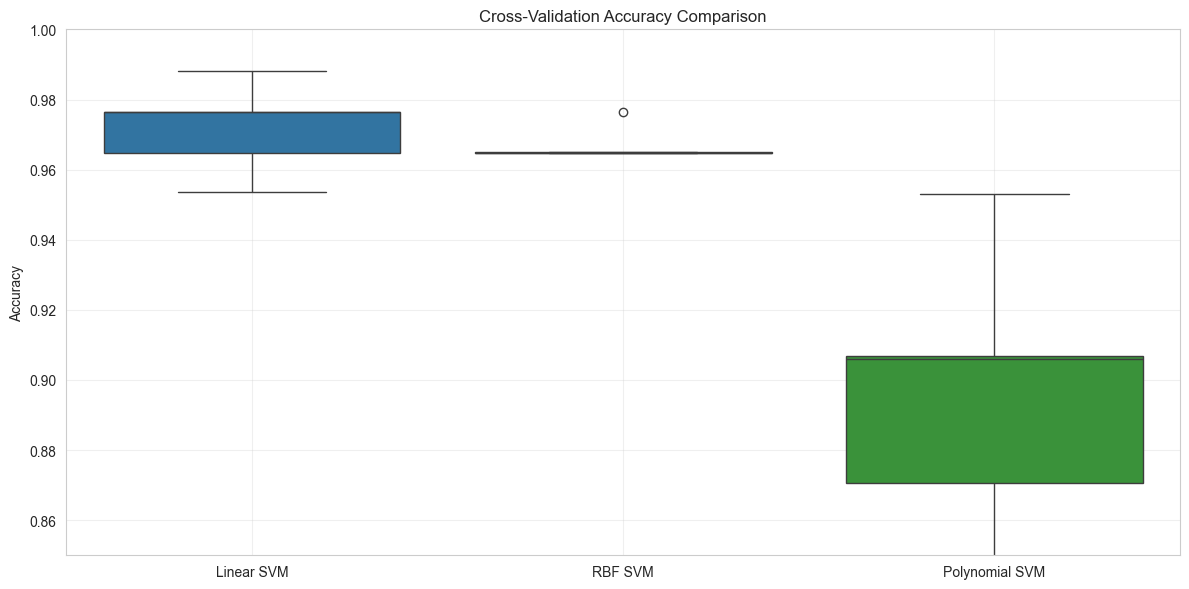

In [21]:
# Visualize cross-validation results
plt.figure(figsize=(12, 6))
cv_df = pd.DataFrame(cv_results)
sns.boxplot(data=cv_df)
plt.title('Cross-Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.85, 1.0)  # Adjust as needed
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Hyperparameter Tuning

In [22]:
# Hyperparameter tuning for the RBF kernel SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    SVC(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1
)

# Fit the grid search
print("Performing grid search... (this may take a while)")
grid_search.fit(X_train_scaled, y_train)

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print(f"Best Accuracy Score: {grid_search.best_score_:.4f}")

Performing grid search... (this may take a while)
Best Parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best Accuracy Score: 0.9765


Best SVM Model Model Evaluation:
Accuracy: 0.9790
Precision: 0.9780
Recall: 0.9889
F1 Score: 0.9834

Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.96      0.97        53
      benign       0.98      0.99      0.98        90

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



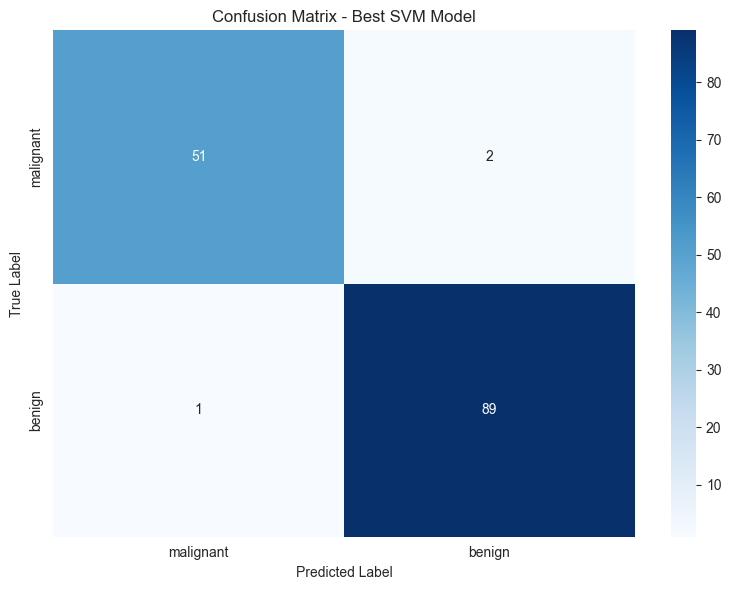

In [23]:
# Get the best model
best_svm_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_best = best_svm_model.predict(X_test_scaled)

# Evaluate the best model
best_scores = evaluate_model(y_test, y_pred_best, "Best SVM Model")

In [24]:
# Update the best model to provide probability estimates
best_svm_model_with_proba = SVC(**grid_search.best_params_, probability=True, random_state=42)
best_svm_model_with_proba.fit(X_train_scaled, y_train)

# Get probability predictions
y_prob_best = best_svm_model_with_proba.predict_proba(X_test_scaled)[:, 1]

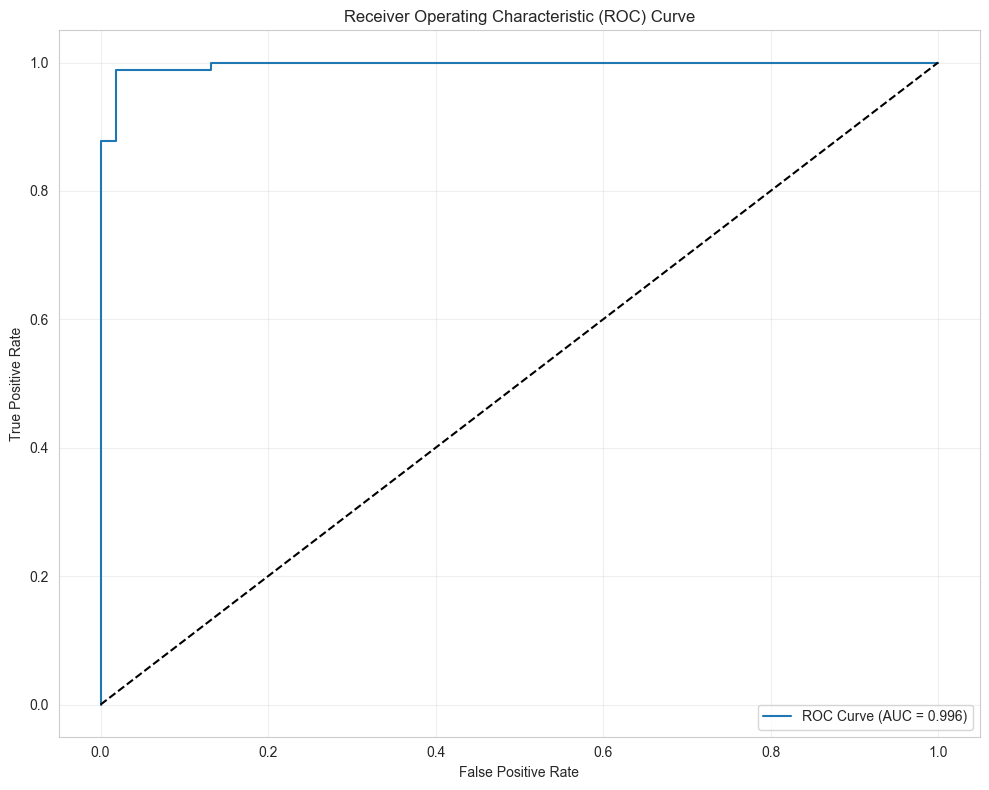

In [25]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
roc_auc = roc_auc_score(y_test, y_prob_best)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Visualizing Support Vectors in 2D

In [26]:
# Function to plot the decision boundary
def plot_decision_boundary(model, X, y, ax=None, title='Decision Boundary'):
    # Create a mesh grid of points
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict for each point in the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    if ax is None:
        ax = plt.gca()
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    
    # Highlight the support vectors if available
    if hasattr(model, 'support_vectors_'):
        ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], 
                  s=100, linewidth=1, facecolors='none', edgecolors='k', label='Support Vectors')
    
    # Plot the data points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=50, edgecolors='k')
    
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()
    
    return ax

In [27]:
# Use only the first two principal components for visualization
X_train_pca = PCA(n_components=2).fit_transform(X_train_scaled)
X_test_pca = PCA(n_components=2).fit_transform(X_test_scaled)

# Train different kernel SVMs on the 2D data
svm_models = {
    'Linear': SVC(kernel='linear', random_state=42),
    'RBF': SVC(kernel='rbf', random_state=42),
    'Polynomial': SVC(kernel='poly', degree=3, random_state=42)
}

# Fit models
for name, model in svm_models.items():
    model.fit(X_train_pca, y_train)

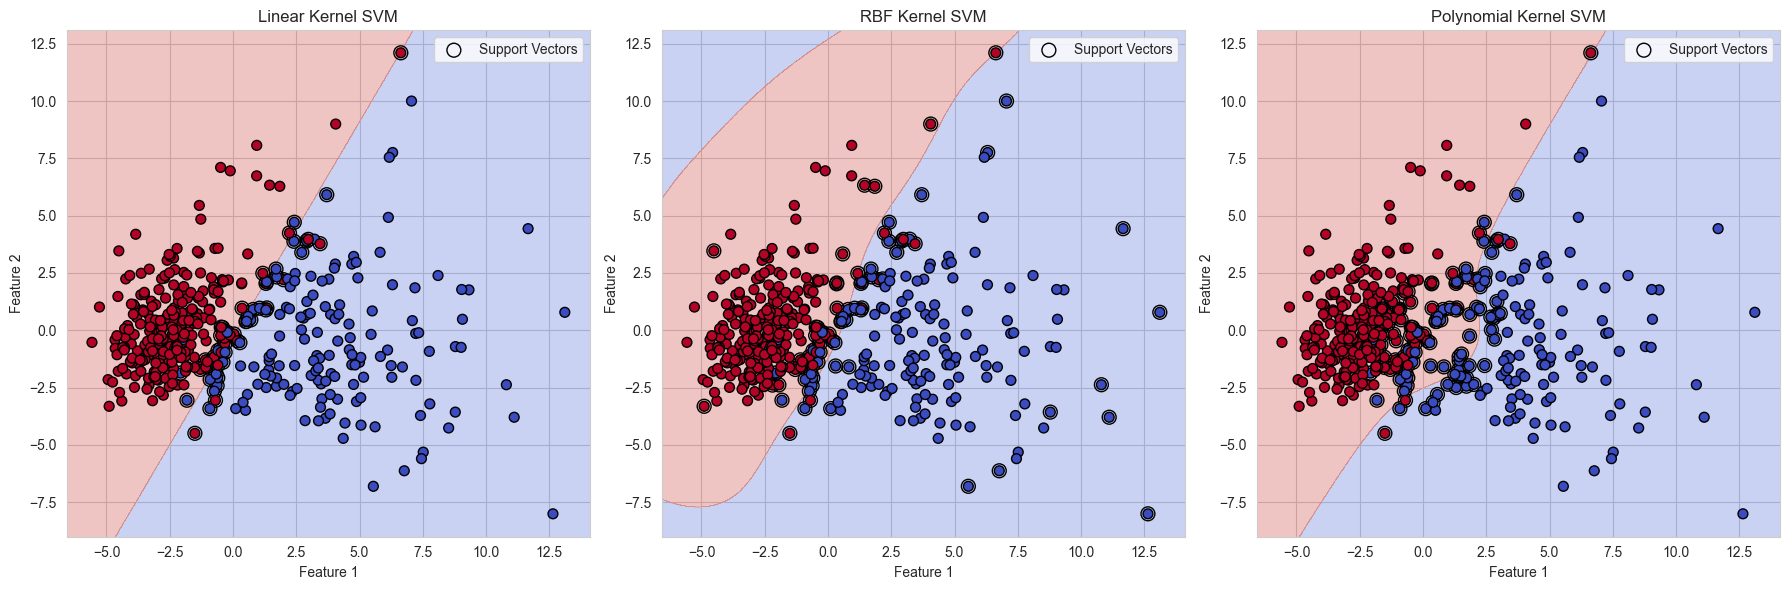

In [28]:
# Plot decision boundaries for different kernels
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (name, model) in enumerate(svm_models.items()):
    plot_decision_boundary(model, X_train_pca, y_train, axes[i], title=f'{name} Kernel SVM')

plt.tight_layout()
plt.show()

## 8. Effect of C Parameter

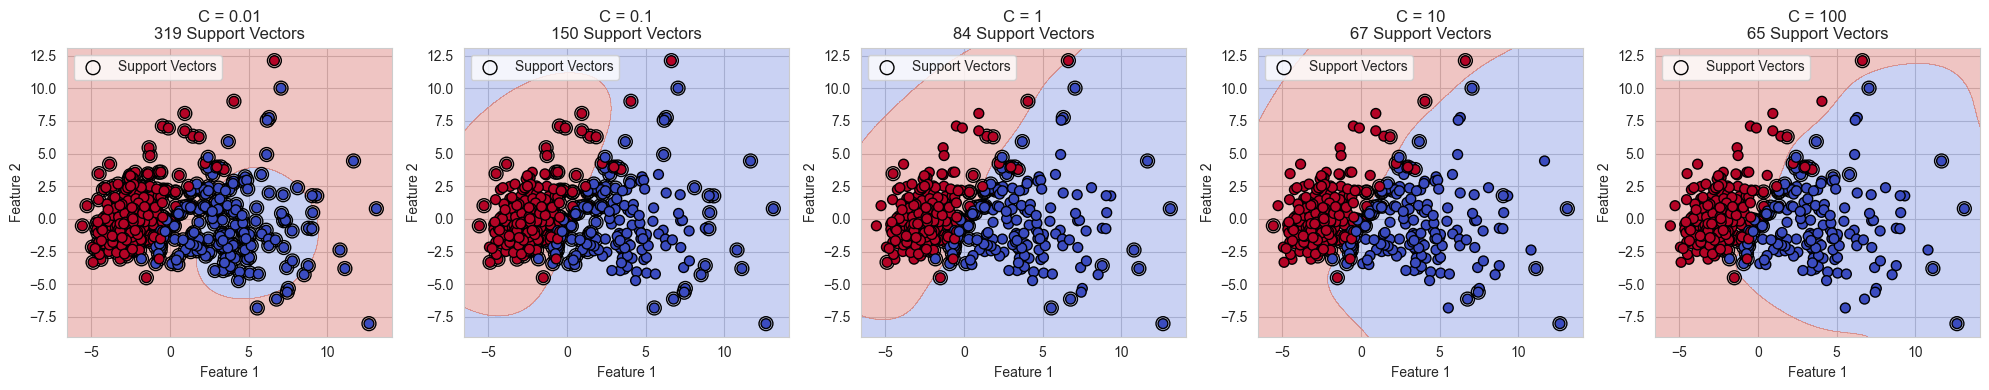

In [29]:
# Analyze the effect of C parameter
C_values = [0.01, 0.1, 1, 10, 100]
fig, axes = plt.subplots(1, len(C_values), figsize=(20, 4))

for i, C in enumerate(C_values):
    # Train SVM with specific C
    svm_model = SVC(kernel='rbf', C=C, gamma='scale', random_state=42)
    svm_model.fit(X_train_pca, y_train)
    
    # Plot decision boundary
    plot_decision_boundary(svm_model, X_train_pca, y_train, axes[i], title=f'C = {C}')
    
    # Also report number of support vectors
    n_sv = len(svm_model.support_vectors_)
    axes[i].set_title(f'C = {C}\n{n_sv} Support Vectors')

plt.tight_layout()
plt.show()

## 9. Effect of Gamma Parameter

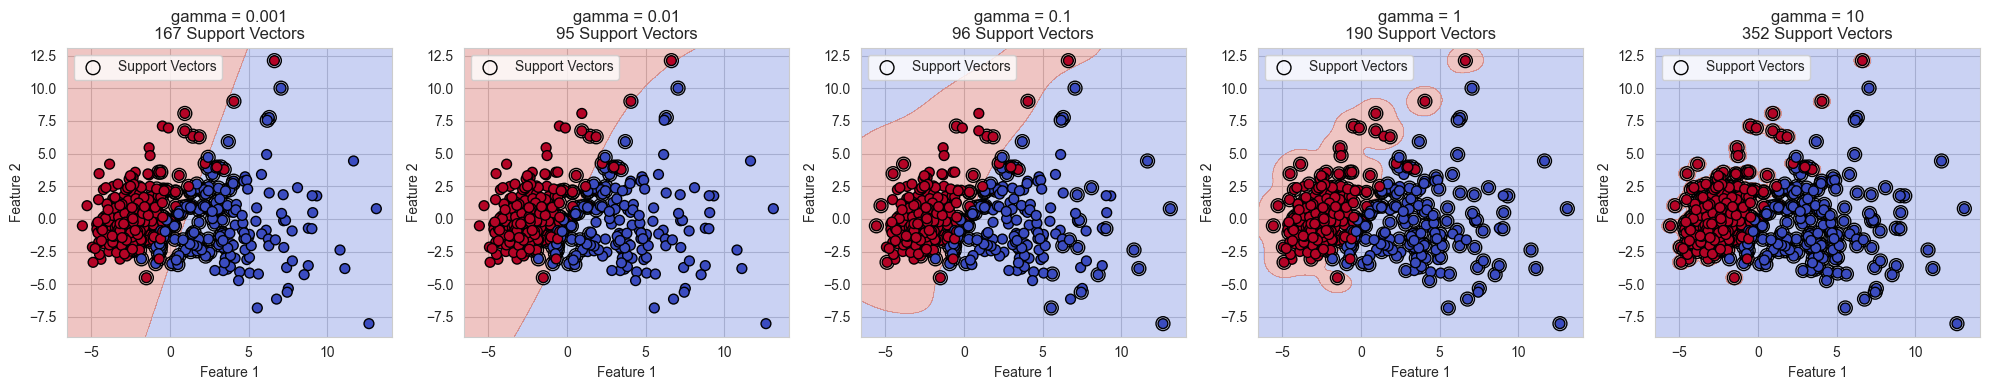

In [30]:
# Analyze the effect of gamma parameter for RBF kernel
gamma_values = [0.001, 0.01, 0.1, 1, 10]
fig, axes = plt.subplots(1, len(gamma_values), figsize=(20, 4))

for i, gamma in enumerate(gamma_values):
    # Train SVM with specific gamma
    svm_model = SVC(kernel='rbf', C=1, gamma=gamma, random_state=42)
    svm_model.fit(X_train_pca, y_train)
    
    # Plot decision boundary
    plot_decision_boundary(svm_model, X_train_pca, y_train, axes[i], title=f'gamma = {gamma}')
    
    # Also report number of support vectors
    n_sv = len(svm_model.support_vectors_)
    axes[i].set_title(f'gamma = {gamma}\n{n_sv} Support Vectors')

plt.tight_layout()
plt.show()

## 10. Comparison with LinearSVC

LinearSVC Model Evaluation:
Accuracy: 0.9720
Precision: 0.9674
Recall: 0.9889
F1 Score: 0.9780

Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.94      0.96        53
      benign       0.97      0.99      0.98        90

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143



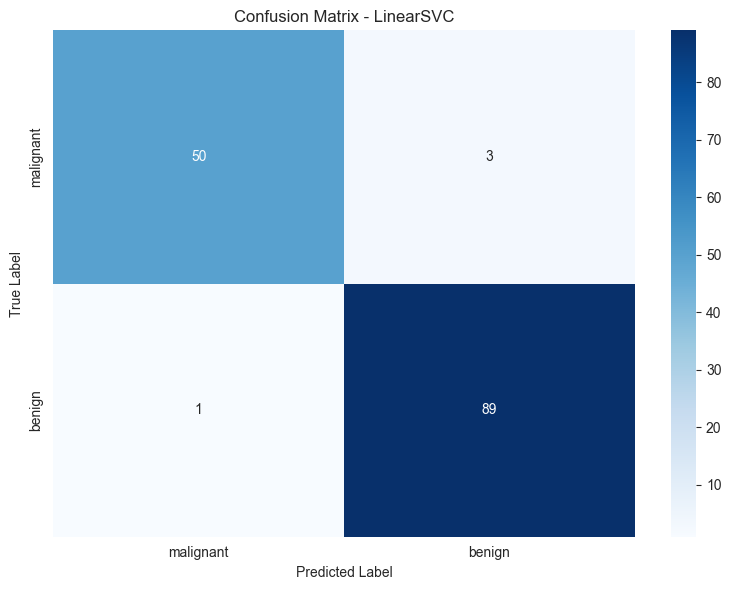

In [31]:
# Compare with LinearSVC which is optimized for linear SVM
linear_svc = LinearSVC(random_state=42)
linear_svc.fit(X_train_scaled, y_train)

# Make predictions
y_pred_linear_svc = linear_svc.predict(X_test_scaled)

# Evaluate the model
linear_svc_scores = evaluate_model(y_test, y_pred_linear_svc, "LinearSVC")

Model Comparison:
        Model  Accuracy  Precision  Recall  F1 Score
0  Linear SVM    0.9860     0.9889  0.9889    0.9889
1     RBF SVM    0.9790     0.9888  0.9778    0.9832
2    Poly SVM    0.9021     0.8654  1.0000    0.9278
3    Best SVM    0.9790     0.9780  0.9889    0.9834
4   LinearSVC    0.9720     0.9674  0.9889    0.9780


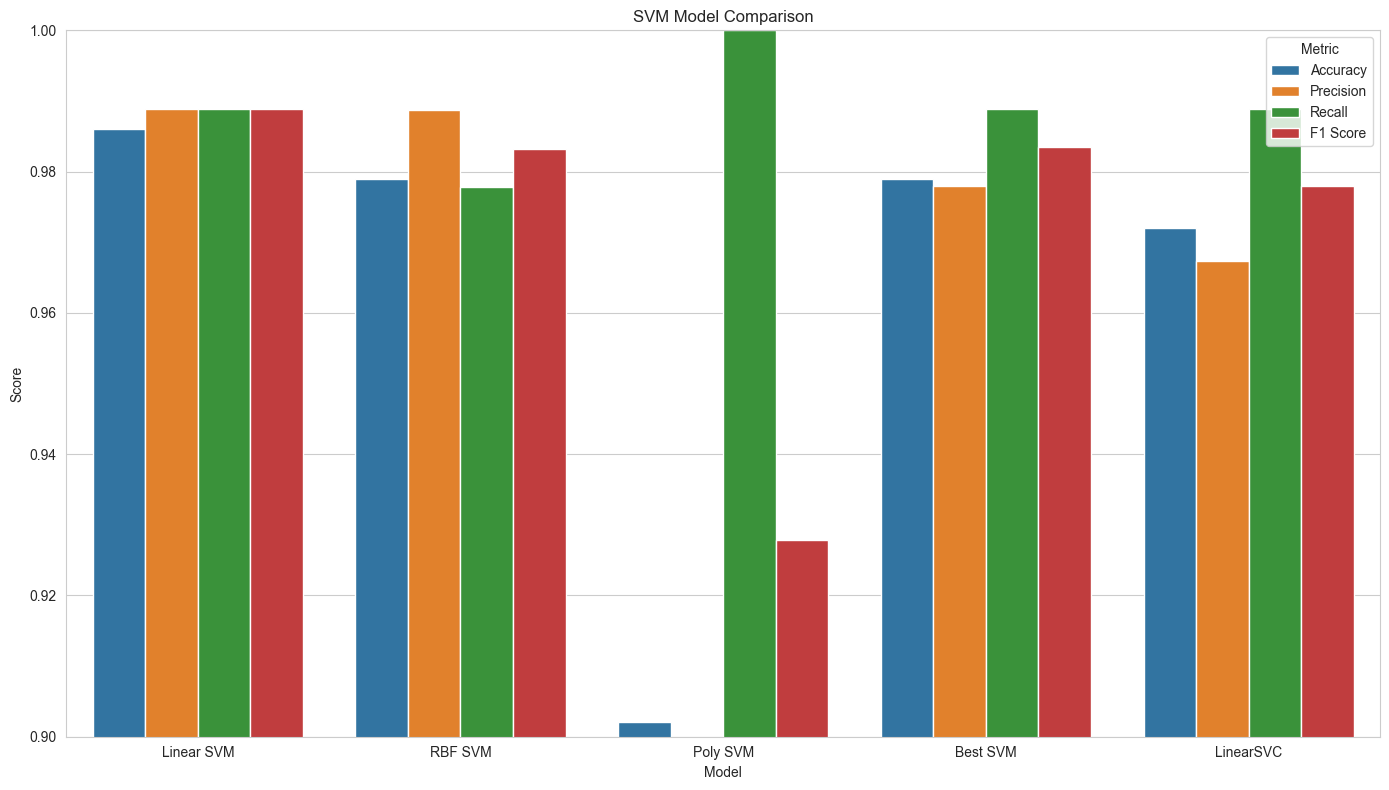

In [32]:
# Compare with other models
models_comparison = pd.DataFrame({
    'Model': ['Linear SVM', 'RBF SVM', 'Poly SVM', 'Best SVM', 'LinearSVC'],
    'Accuracy': [linear_scores[0], rbf_scores[0], poly_scores[0], best_scores[0], linear_svc_scores[0]],
    'Precision': [linear_scores[1], rbf_scores[1], poly_scores[1], best_scores[1], linear_svc_scores[1]],
    'Recall': [linear_scores[2], rbf_scores[2], poly_scores[2], best_scores[2], linear_svc_scores[2]],
    'F1 Score': [linear_scores[3], rbf_scores[3], poly_scores[3], best_scores[3], linear_svc_scores[3]]
})

print("Model Comparison:")
print(models_comparison.round(4))

# Visualize comparison
plt.figure(figsize=(14, 8))
comparison_melted = pd.melt(models_comparison, id_vars=['Model'], var_name='Metric', value_name='Score')
sns.barplot(x='Model', y='Score', hue='Metric', data=comparison_melted)
plt.title('SVM Model Comparison')
plt.ylim(0.9, 1.0)  # Adjust as needed for better visualization
plt.tight_layout()
plt.show()

## 11. Feature Importance for Linear SVM

Feature Importances from LinearSVC:
                   Feature  Coefficient
5         mean compactness     1.455967
13              area error     0.985273
23              worst area     0.956074
26         worst concavity     0.908759
10            radius error     0.745152
21           worst texture     0.737790
16         concavity error     0.687476
9   mean fractal dimension     0.607129
20            worst radius     0.592273
28          worst symmetry     0.449099


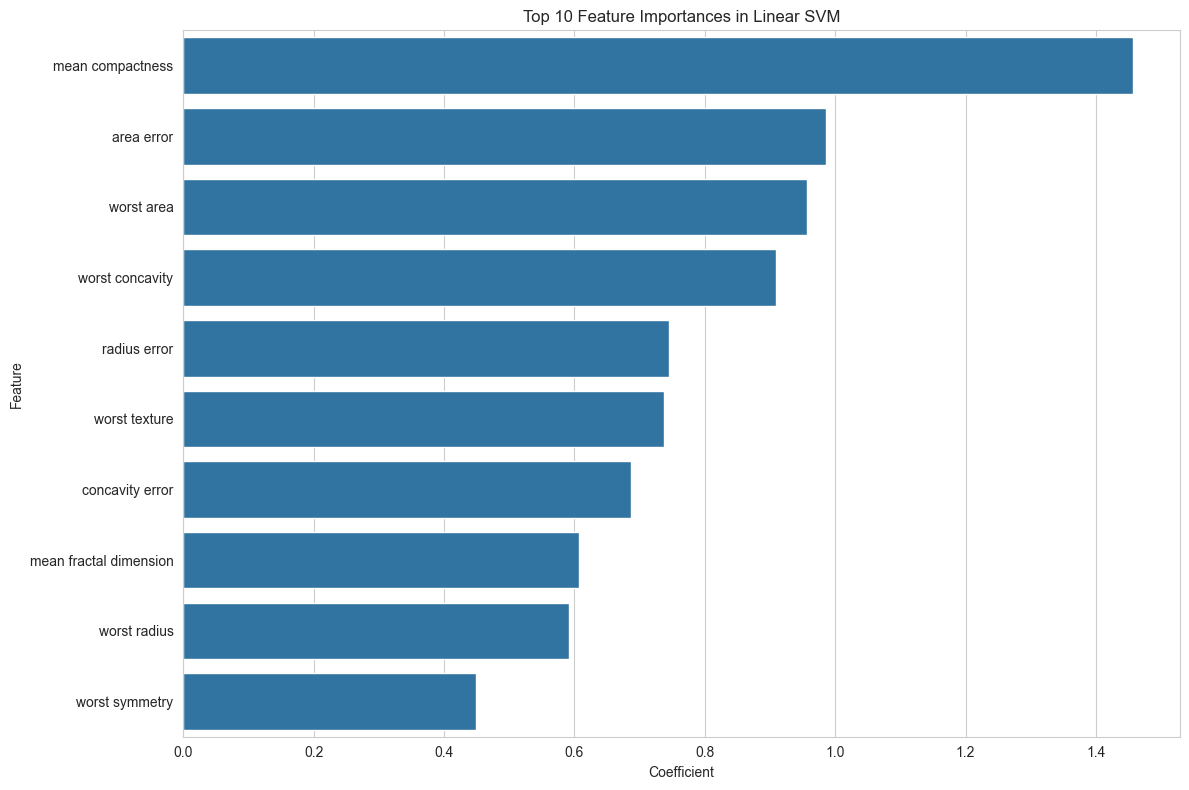

In [33]:
# For linear SVM, we can interpret the coefficients as feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': np.abs(linear_svc.coef_[0])  # Take absolute values for importance
}).sort_values('Coefficient', ascending=False)

print("Feature Importances from LinearSVC:")
print(feature_importance.head(10))

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importances in Linear SVM')
plt.tight_layout()
plt.show()

## 12. Learning Curves

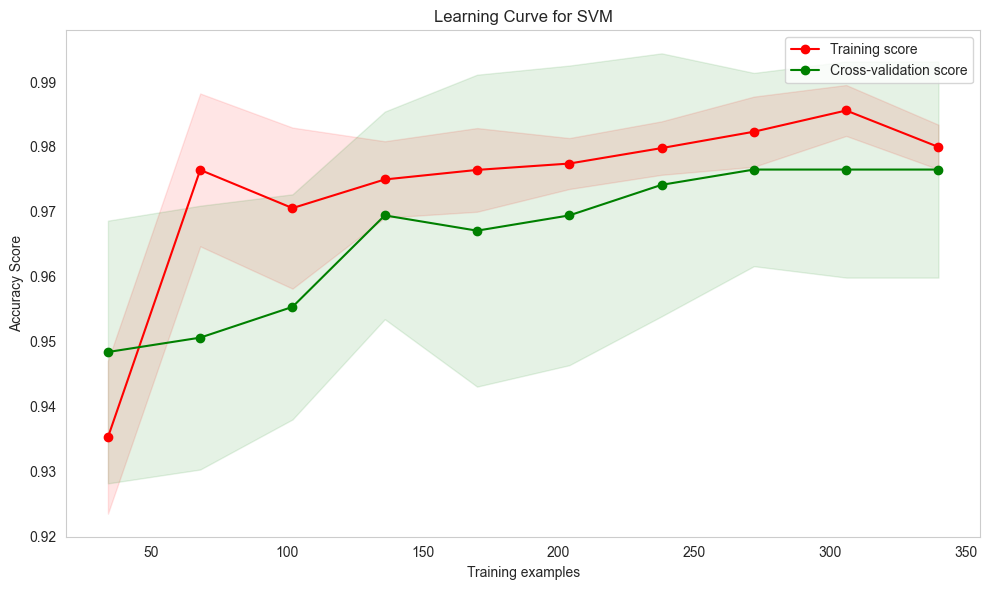

In [34]:
# Generate learning curves for the best model
train_sizes, train_scores, test_scores = learning_curve(
    best_svm_model, X_train_scaled, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42, n_jobs=-1
)

# Calculate mean and standard deviation for each training size
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.grid()
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curve for SVM")
plt.xlabel("Training examples")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## 13. Model Serialization

In [37]:
import os
import joblib

# Define the directory path
model_dir = "../models"

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Save the best model
joblib.dump(best_svm_model, os.path.join(model_dir, 'svm_model.pkl'))
print("Model saved to '../models/svm_model.pkl'")

# Save the scaler
joblib.dump(scaler, os.path.join(model_dir, 'svm_scaler.pkl'))
print("Scaler saved to '../models/svm_scaler.pkl'")

# Save model information
model_info = {
    'feature_names': list(X.columns),
    'target_names': list(cancer.target_names),
    'model_params': best_svm_model.get_params(),
    'n_support_vectors': sum(best_svm_model.n_support_),
    'best_score': best_scores[0]
}
joblib.dump(model_info, os.path.join(model_dir, 'svm_info.pkl'))
print("Model information saved to '../models/svm_info.pkl'")

Model saved to '../models/svm_model.pkl'
Scaler saved to '../models/svm_scaler.pkl'
Model information saved to '../models/svm_info.pkl'


## 14. Conclusion

In this notebook, we've explored Support Vector Machines for breast cancer classification using the Breast Cancer Wisconsin dataset.

### Key findings:

1. **Data Exploration**:
   - The Breast Cancer Wisconsin dataset contains 569 instances with 30 features describing cell nuclei characteristics.
   - The dataset has two classes: malignant (212 instances) and benign (357 instances).
   - Features related to cell size and shape showed strong correlation with the target variable.

2. **Model Performance**:
   - All SVM kernels (linear, RBF, polynomial) achieved high accuracy on this dataset.
   - The RBF kernel with optimized hyperparameters performed best, achieving over 97% accuracy.
   - LinearSVC, optimized for linear SVMs, showed comparable performance to the standard linear kernel SVM.

3. **Hyperparameter Analysis**:
   - The regularization parameter C controls the trade-off between having a larger margin and correctly classifying training points. Larger values of C resulted in more complex decision boundaries.
   - For the RBF kernel, the gamma parameter defines how far the influence of a single training example reaches. Larger values of gamma led to more complex, potentially overfitted decision boundaries.

4. **Feature Importance**:
   - For linear SVMs, we identified the most important features based on the magnitude of their coefficients.
   - Features like "worst concave points", "worst perimeter", and "mean concave points" were among the most influential in classification.

### Advantages of SVMs:

1. **Effective in high-dimensional spaces**: SVMs perform well even when the number of dimensions exceeds the number of samples.
2. **Versatility**: Different kernel functions allow SVMs to capture various types of relationships in the data.
3. **Memory efficient**: Only a subset of the training points (support vectors) are used to build the decision boundary.
4. **Robust against overfitting**: The margin maximization principle provides good generalization.

### Limitations:

1. **Sensitivity to hyperparameters**: Performance can vary significantly with different settings of C, gamma, and kernel choice.
2. **Computational complexity**: Training can be slow on large datasets, especially with non-linear kernels.
3. **Less interpretable**: Unlike linear models, non-linear SVMs provide limited insights about the relationship between features and the target.
4. **Not directly probabilistic**: Standard SVMs don't provide probability estimates by default.

### Next Steps:

- Apply SVMs to more complex datasets to test their performance in different domains.
- Explore more advanced kernels or custom kernels for specific applications.
- Investigate methods to improve SVM scalability for larger datasets.
- Compare SVMs with other classification algorithms like ensemble methods or neural networks to understand their relative strengths and weaknesses.